# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [2]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


# Data Preparation

In [21]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [3]:
# Check for missing values
print("Missing values before:")
print(df.isnull().sum())

# Fill in N/A
cat_feats = ['lead_source', 'industry', 'employment_status', 'location']
num_feats = ['annual_income']

# Replace missing values
df[cat_feats] = df[cat_feats].fillna('NA')
df[num_feats] = df[num_feats].fillna(0.0)

# Check missing values once again
print("Missing values after:")
print(df.isnull().sum())


Missing values before:
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64
Missing values after:
lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


In [37]:
# Split 60/20/20%
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

X_train = df_train.reset_index(drop=True)
X_val = df_val.reset_index(drop=True)
X_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

# Delete label
del X_train['converted']
del X_val['converted']
del X_test['converted']

# Check distribution
print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Train set: 876 samples
Validation set: 293 samples
Test set: 293 samples


# Question 1

In [38]:
features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_scores = {}

for feat in features:
    # Compute ROC AUC using the feature as a score
    auc = roc_auc_score(y_train, X_train[feat])
    
    # If AUC < 0.5 → feature is negatively correlated with the target
    # So we invert it (multiply by -1)
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[feat])
    
    auc_scores[feat] = auc

# Sort by AUC descending
sorted_auc = dict(sorted(auc_scores.items(), key=lambda x: x[1], reverse=True))

print(sorted_auc)
feature, auc = next(iter(sorted_auc.items()))
print(f"Feature: {feature} has highest AUC: {auc}.")

{'number_of_courses_viewed': 0.7635680590007088, 'interaction_count': 0.738270176293409, 'lead_score': 0.6144993577250176, 'annual_income': 0.5519578313253012}
Feature: number_of_courses_viewed has highest AUC: 0.7635680590007088.


# Question 2

In [39]:
dv = DictVectorizer(sparse=False)
train_dict = X_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = X_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dit = X_test.to_dict(orient='records')
X_test = dv.transform(test_dit)

In [40]:
# Fit the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [42]:
# Perform predition and compute the accuracy
y_val_pred = model.predict_proba(X_val)[:, 1]
accuracy = (y_val == (y_val_pred >= 0.5)).mean()
print(f"Accuracy on the validation set: {round(accuracy, 3)}")

Accuracy on the validation set: 0.7


# Question 3

0.64


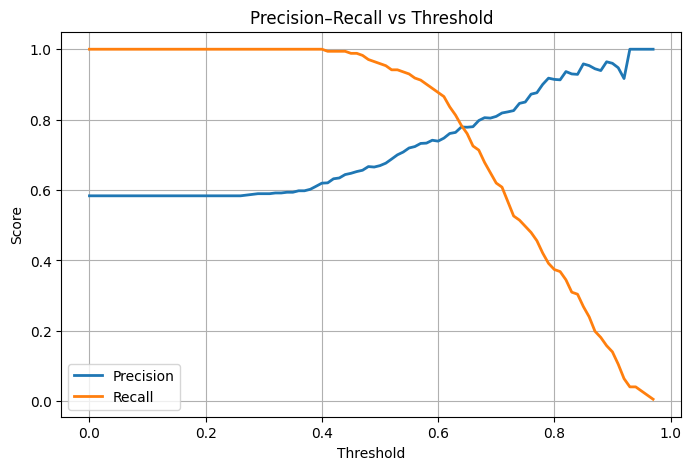

In [44]:
precisions = []
recalls = []

thresholds = np.arange(0, 1, 0.01)
valid_thresholds = []
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_val_pred >= t)
    predict_negative = (y_val_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    if (tp + fp) == 0:
        continue  # Avoid no positives

    # precision
    p = tp / (tp + fp)
    precisions.append(p)

    # recall
    r = tp / (tp + fn)
    recalls.append(r)

    valid_thresholds.append(t)

# Plot precision and recall vs threshold
plt.figure(figsize=(8,5))
plt.plot(valid_thresholds, precisions, label='Precision', linewidth=2)
plt.plot(valid_thresholds, recalls, label='Recall', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision–Recall vs Threshold')
plt.legend()
plt.grid(True)

# Find intersection point
precisions = np.array(precisions)
recalls = np.array(recalls)
valid_thresholds = np.array(valid_thresholds)

diff = np.abs(precisions - recalls)
best_idx = np.argmin(diff)
best_threshold = valid_thresholds[best_idx]
print(best_threshold)

# Question 4

In [12]:
f1s = []

thresholds = np.arange(0, 1, 0.01)
valid_thresholds = []
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_val_pred >= t)
    predict_negative = (y_val_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    if (tp + fp) == 0:
        continue  # Avoid no positives

    # precision
    p = tp / (tp + fp)

    # recall
    r = tp / (tp + fn)

    # f1
    f1 = 2 * p * r / (p + r)
    f1s.append(f1)

    valid_thresholds.append(t)

best_idx = np.argmax(f1s)
best_threshold = valid_thresholds[best_idx]
print(best_threshold)
print(f1s[best_idx])

0.5700000000000001
0.8124999999999999


# Question 5

In [45]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model


def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [48]:
# Define KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kf.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    # Define and train the model
    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

# Compute mean and standard deviation
std_auc = np.std(scores)
print(f"STD: {std_auc}")

STD: 0.03580711942905165


# Question 7

In [49]:
C = [0.000001, 0.001, 1]
for c in C:
    # Define KFold cross-validator
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kf.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        # Define and train the model
        dv, model = train(df_train, y_train, C=c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    # Compute mean and standard deviation
    mean_auc = np.mean(scores)
    std_auc = np.std(scores)
    print(f"C: {c}. Mean: {round(mean_auc, 3)}. STD: {round(std_auc, 3)}")

C: 1e-06. Mean: 0.56. STD: 0.024
C: 0.001. Mean: 0.867. STD: 0.029
C: 1. Mean: 0.822. STD: 0.036
